# World Bank Data Acquisition & Processing

This notebook fetches climate data (CCKP) and economic/agricultural data (WDI) from the World Bank APIs.

### Data Sources:
- **CCKP (Climate Change Knowledge Portal)**: Historical Temperature and Rainfall data.
- **WDI (World Development Indicators)**: GDP and Agricultural Land percentage.

In [11]:
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Set plot style
sns.set(style="whitegrid")

## 2. API Helper Functions

Define helper functions to interact with World Bank APIs.

In [2]:
def fetch_cckp_data(variable):
    """
    Fetches historical climate data from the World Bank CCKP API.
    """
    url = (
        f"https://cckpapi.worldbank.org/cckp/v1/"
        f"cru-x0.5_timeseries_{variable}_timeseries_annual_1901-2022_mean_"
        f"historical_cru_ts4.07_mean/all_countries?_format=json"
    )
    print(f"Fetching {variable} from {url}...")
    try:
        r = requests.get(url)
        if r.status_code != 200:
            print(f"Failed to fetch data: {r.status_code}")
            return None
        data = r.json()
        if "data" not in data:
            print("Unexpected structure:", data)
            return None
        output_rows = []
        for iso3, year_dict in data["data"].items():
            if not isinstance(year_dict, dict):
                continue
            for date_str, value in year_dict.items():
                year = int(date_str.split("-")[0])
                output_rows.append({
                    "ISO3": iso3,
                    "Year": year,
                    "Value": value,
                    "Indicator": variable
                })
        df = pd.DataFrame(output_rows)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None


In [3]:
def fetch_wdi_data(indicator):
    """
    Fetch full WDI data for all countries.
    """
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}"
    params = {
        "format": "json",
        "per_page": 20000,
        "date": "1960:2025"
    }
    print(f"Fetching WDI indicator '{indicator}'...")
    all_rows = []
    page = 1
    while True:
        params["page"] = page
        r = requests.get(url, params=params)
        if r.status_code != 200:
            print(f"Error fetching page {page}: {r.status_code}")
            break
        data = r.json()
        if not isinstance(data, list) or len(data) < 2:
            break
        meta, rows = data
        all_rows.extend(rows)
        if page >= meta.get("pages", 1):
            break
        page += 1
    if not all_rows:
        print("No data returned.")
        return None
    df = pd.DataFrame(all_rows)
    df = df[["countryiso3code", "country", "date", "value"]].dropna(subset=["value"])
    df.rename(columns={
        "countryiso3code": "ISO3",
        "country": "Country",
        "date": "Year",
        "value": "Value"
    }, inplace=True)
    df["Year"] = df["Year"].astype(int)
    df["Country"] = df["Country"].apply(lambda x: x["value"] if isinstance(x, dict) else x)
    df["Indicator"] = indicator
    return df


## 3. Fetch Data

Retrieve Temperature, Rainfall, GDP, and Agricultural Land data.

In [4]:
df_temp = fetch_cckp_data('tas')
df_rain = fetch_cckp_data('pr')
df_gdp = fetch_wdi_data('NY.GDP.MKTP.CD')
df_land = fetch_wdi_data('AG.LND.AGRI.ZS')

Fetching tas from https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_tas_timeseries_annual_1901-2022_mean_historical_cru_ts4.07_mean/all_countries?_format=json...
Fetching pr from https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_pr_timeseries_annual_1901-2022_mean_historical_cru_ts4.07_mean/all_countries?_format=json...
Fetching WDI indicator 'NY.GDP.MKTP.CD'...
Fetching WDI indicator 'AG.LND.AGRI.ZS'...


## 4. Process and Map Indicators

Map variable codes to readable names.

In [5]:
indicator_map = {
    "tas": "Temperature (C)",
    "pr": "Rainfall (mm)",
    "NY.GDP.MKTP.CD": "GDP (USD)",
    "AG.LND.AGRI.ZS": "Agricultural Land (%)"
}

In [6]:
for df in [df_temp, df_rain, df_gdp, df_land]:
    df["Indicator"] = df["Indicator"].map(indicator_map)

In [7]:
df_temp.head()

,ISO3,Year,Value,Indicator
0,ABW,1901,28.22,Temperature (C)
1,ABW,1902,27.79,Temperature (C)
2,ABW,1903,27.89,Temperature (C)
3,ABW,1904,27.62,Temperature (C)
4,ABW,1905,27.68,Temperature (C)


In [8]:
df_rain.head()

,ISO3,Year,Value,Indicator
0,ABW,1901,420.9,Rainfall (mm)
1,ABW,1902,420.9,Rainfall (mm)
2,ABW,1903,420.9,Rainfall (mm)
3,ABW,1904,420.9,Rainfall (mm)
4,ABW,1905,420.9,Rainfall (mm)


In [9]:
df_gdp.head()

,ISO3,Country,Year,Value,Indicator
0,AFE,Africa Eastern and Southern,2024,1.205974e+12,GDP (USD)
1,AFE,Africa Eastern and Southern,2023,1.133818e+12,GDP (USD)
2,AFE,Africa Eastern and Southern,2022,1.191639e+12,GDP (USD)
3,AFE,Africa Eastern and Southern,2021,1.085605e+12,GDP (USD)
4,AFE,Africa Eastern and Southern,2020,9.334072e+11,GDP (USD)


In [10]:
df_land.head()

,ISO3,Country,Year,Value,Indicator
2,AFE,Africa Eastern and Southern,2022,46.541210,Agricultural Land (%)
3,AFE,Africa Eastern and Southern,2021,46.510566,Agricultural Land (%)
4,AFE,Africa Eastern and Southern,2020,46.456976,Agricultural Land (%)
5,AFE,Africa Eastern and Southern,2019,46.419179,Agricultural Land (%)
6,AFE,Africa Eastern and Southern,2018,46.369558,Agricultural Land (%)


In [11]:
df_gdp.shape

(14541, 5)

In [12]:
df_land.shape

(15097, 5)

In [13]:
df_rain.shape

(30012, 4)

In [14]:
df_temp.shape

(30012, 4)

In [15]:
# Create ISO3 to Country mapping
country_map = pd.DataFrame()
country_map = pd.concat([country_map, df_gdp[['ISO3', 'Country']]])

country_map = pd.concat([country_map, df_land[['ISO3', 'Country']]])

country_map = country_map.drop_duplicates('ISO3').set_index('ISO3')

In [16]:
dfs = [df for df in [df_temp, df_rain, df_gdp, df_land] if df is not None]

In [17]:
dfs

[      ISO3  Year  Value        Indicator
 0      ABW  1901  28.22  Temperature (C)
 1      ABW  1902  27.79  Temperature (C)
 2      ABW  1903  27.89  Temperature (C)
 3      ABW  1904  27.62  Temperature (C)
 4      ABW  1905  27.68  Temperature (C)
 ...    ...   ...    ...              ...
 30007  ZWE  2018  22.09  Temperature (C)
 30008  ZWE  2019  22.37  Temperature (C)
 30009  ZWE  2020  21.93  Temperature (C)
 30010  ZWE  2021  21.87  Temperature (C)
 30011  ZWE  2022  21.83  Temperature (C)
 
 [30012 rows x 4 columns],
       ISO3  Year   Value      Indicator
 0      ABW  1901  420.90  Rainfall (mm)
 1      ABW  1902  420.90  Rainfall (mm)
 2      ABW  1903  420.90  Rainfall (mm)
 3      ABW  1904  420.90  Rainfall (mm)
 4      ABW  1905  420.90  Rainfall (mm)
 ...    ...   ...     ...            ...
 30007  ZWE  2018  635.43  Rainfall (mm)
 30008  ZWE  2019  732.28  Rainfall (mm)
 30009  ZWE  2020  684.29  Rainfall (mm)
 30010  ZWE  2021  634.60  Rainfall (mm)
 30011  ZWE  202

## 5. Merge and Pivot Data

Combine all datasets, pivot to wide format, and merge with country metadata.

In [18]:
df_combined = pd.concat(dfs, ignore_index=True)
df_pivot = df_combined.pivot_table(index=['ISO3', 'Year'], columns='Indicator', values='Value').reset_index()

df_final = df_pivot.merge(country_map, on='ISO3', how='left')
cols = ['ISO3', 'Country', 'Year'] + [c for c in df_final.columns if c not in ['ISO3', 'Country', 'Year']]
df_final = df_final[cols]

In [19]:
df_final

,ISO3,Country,Year,Agricultural Land (%),GDP (USD),Rainfall (mm),Temperature (C)
0,,High income,1960,NaN,4.491618e+11,NaN,NaN
1,,High income,1961,35.357332,4.745719e+11,NaN,NaN
2,,High income,1962,35.427645,5.073186e+11,NaN,NaN
3,,High income,1963,35.507262,5.480090e+11,NaN,NaN
4,,High income,1964,35.591040,6.032826e+11,NaN,NaN
...,...,...,...,...,...,...,...
33156,ZWE,Zimbabwe,2020,41.816960,2.686856e+10,684.29,21.93
33157,ZWE,Zimbabwe,2021,41.809145,2.724051e+10,634.60,21.87
33158,ZWE,Zimbabwe,2022,41.797711,3.278966e+10,725.28,21.83
33159,ZWE,Zimbabwe,2023,41.791706,3.523137e+10,NaN,NaN


In [20]:
df_final.isnull().sum()

ISO3                         0
Country                   3660
Year                         0
Agricultural Land (%)    18250
GDP (USD)                18808
Rainfall (mm)             3393
Temperature (C)           3393
dtype: int64

In [21]:
df_final['Country'] = (
    df_final.groupby('ISO3')['Country']
    .transform(lambda x: x.ffill().bfill())
)

/var/folders/sw/jvm_9vs95tj9mj54z576clt40000gn/T/ipykernel_77342/2753601161.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.ffill().bfill())


In [22]:
numeric_cols = ["Temperature (C)", "Rainfall (mm)", 
                "GDP (USD)", "Agricultural Land (%)"]

df_final[numeric_cols] = (
    df_final.groupby("ISO3")[numeric_cols]
    .transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
)

In [23]:
df_final.isnull().sum()

ISO3                        0
Country                  3660
Year                        0
Agricultural Land (%)    4293
GDP (USD)                3906
Rainfall (mm)            2998
Temperature (C)          2998
dtype: int64

In [24]:
# Fetch region info
region_url = "https://api.worldbank.org/v2/country?format=json&per_page=500"
r = requests.get(region_url).json()

region_map = {
    item["id"]: item["region"]["value"]
    for item in r[1]
    if "region" in item
}

df_final["Region"] = df_final["ISO3"].map(region_map)

In [25]:
for col in numeric_cols:
    df_final[col] = df_final.groupby("Region")[col].transform(
        lambda x: x.fillna(x.median())
    )

/Users/nagavenkatasaimaheshandey/Desktop/agro-climatic-forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/nagavenkatasaimaheshandey/Desktop/agro-climatic-forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [26]:
df_final[numeric_cols] = df_final[numeric_cols].fillna(
    df_final[numeric_cols].median()
)

In [27]:
df_final.isnull().sum()

ISO3                        0
Country                  3660
Year                        0
Agricultural Land (%)       0
GDP (USD)                   0
Rainfall (mm)               0
Temperature (C)             0
Region                   3603
dtype: int64

In [28]:
df_final[df_final['Country'].isna()]

,ISO3,Country,Year,Agricultural Land (%),GDP (USD),Rainfall (mm),Temperature (C),Region
565,AIA,NaN,1901,37.23943,3.749265e+09,1060.12,22.89,NaN
566,AIA,NaN,1902,37.23943,3.749265e+09,1060.12,22.89,NaN
567,AIA,NaN,1903,37.23943,3.749265e+09,1060.12,22.89,NaN
568,AIA,NaN,1904,37.23943,3.749265e+09,1060.12,22.89,NaN
569,AIA,NaN,1905,37.23943,3.749265e+09,1060.12,22.89,NaN
...,...,...,...,...,...,...,...,...
32520,WLF,NaN,2018,37.23943,3.749265e+09,1060.12,22.89,NaN
32521,WLF,NaN,2019,37.23943,3.749265e+09,1060.12,22.89,NaN
32522,WLF,NaN,2020,37.23943,3.749265e+09,1060.12,22.89,NaN
32523,WLF,NaN,2021,37.23943,3.749265e+09,1060.12,22.89,NaN


In [29]:
import pycountry

def get_country_name(iso):
    try:
        return pycountry.countries.get(alpha_3=iso).name
    except:
        return None

In [30]:
df_final['Country'] = df_final.apply(
    lambda row: get_country_name(row['ISO3']) if pd.isna(row['Country']) else row['Country'],
    axis=1
)

In [31]:
df_final[df_final['Region'].isna()]['ISO3'].unique()

array(['', 'AIA', 'ALA', 'ATF', 'BES', 'CCK', 'COK', 'CXR', 'GGY', 'GLP',
       'GUF', 'HMD', 'IOT', 'JEY', 'KSV', 'MSR', 'MTQ', 'MYT', 'NFK',
       'NIU', 'PCN', 'REU', 'SHN', 'SJM', 'SPM', 'TKL', 'TWN', 'UMI',
       'VAT', 'WLF'], dtype=object)

In [33]:
region_map_extra = {
    "AIA": "Latin America & Caribbean",        # Anguilla
    "ALA": "Europe & Central Asia",            # Åland Islands
    "ATF": "South Asia",                       # French Southern Territories (assigned to South Asia region per WB)
    "BES": "Latin America & Caribbean",        # Bonaire, Sint Eustatius and Saba
    "CCK": "East Asia & Pacific",              # Cocos (Keeling) Islands
    "COK": "East Asia & Pacific",              # Cook Islands
    "CXR": "East Asia & Pacific",              # Christmas Island
    "GGY": "Europe & Central Asia",            # Guernsey
    "GLP": "Latin America & Caribbean",        # Guadeloupe
    "GUF": "Latin America & Caribbean",        # French Guiana
    "HMD": "South Asia",                       # Heard Island & McDonald Islands (WB assigns to South Asia)
    "IOT": "South Asia",                       # British Indian Ocean Territory
    "JEY": "Europe & Central Asia",            # Jersey
    "KSV": "Europe & Central Asia",            # Kosovo (WB uses "Europe & Central Asia")
    "MSR": "Latin America & Caribbean",        # Montserrat
    "MTQ": "Latin America & Caribbean",        # Martinique
    "MYT": "Sub-Saharan Africa",               # Mayotte (Africa region)
    "NFK": "East Asia & Pacific",              # Norfolk Island
    "NIU": "East Asia & Pacific",              # Niue
    "PCN": "East Asia & Pacific",              # Pitcairn Islands
    "REU": "Sub-Saharan Africa",               # Réunion
    "SHN": "Sub-Saharan Africa",               # Saint Helena
    "SJM": "Europe & Central Asia",            # Svalbard & Jan Mayen
    "SPM": "Europe & Central Asia",            # Saint Pierre and Miquelon
    "TKL": "East Asia & Pacific",              # Tokelau
    "TWN": "East Asia & Pacific",              # Taiwan
    "UMI": "East Asia & Pacific",              # U.S. Minor Outlying Islands
    "VAT": "Europe & Central Asia",            # Vatican City
    "WLF": "East Asia & Pacific",              # Wallis & Futuna
}

In [34]:
df_final['Region'] = df_final.apply(
    lambda row: region_map_extra.get(row['ISO3'], row['Region']),
    axis=1
)

In [35]:
df_final = df_final[df_final['ISO3'] != '']

In [36]:
df_final[df_final['Region'].isna()]

,ISO3,Country,Year,Agricultural Land (%),GDP (USD),Rainfall (mm),Temperature (C),Region


In [37]:
df_final[df_final['Country'].isna()]

,ISO3,Country,Year,Agricultural Land (%),GDP (USD),Rainfall (mm),Temperature (C),Region
15950,KSV,None,1901,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
15951,KSV,None,1902,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
15952,KSV,None,1903,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
15953,KSV,None,1904,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
15954,KSV,None,1905,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
...,...,...,...,...,...,...,...,...
16067,KSV,None,2018,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
16068,KSV,None,2019,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
16069,KSV,None,2020,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia
16070,KSV,None,2021,37.23943,3.749265e+09,1060.12,22.89,Europe & Central Asia


In [38]:
df_final.loc[df_final['ISO3'] == 'KSV', 'Country'] = 'Kosovo'

In [39]:
df_final.isnull().sum()

ISO3                     0
Country                  0
Year                     0
Agricultural Land (%)    0
GDP (USD)                0
Rainfall (mm)            0
Temperature (C)          0
Region                   0
dtype: int64

In [40]:
df_final.shape

(33096, 8)

In [ ]:
df = df_final.drop_duplicates()

In [ ]:
df["ISO3"] = df["ISO3"].astype(str).str.upper()
df["Country"] = df["Country"].astype(str).str.title()
df["Region"] = df["Region"].astype("category")
df["Year"] = df["Year"].astype(int)

In [ ]:
num_cols = ["Agricultural Land (%)", "GDP (USD)", "Rainfall (mm)", "Temperature (C)"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [ ]:
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

df.head()

,ISO3,Country,Year,Agricultural Land (%),GDP (USD),Rainfall (mm),Temperature (C),Region
0,ABW,Aruba,1901,11.111111,4.055866e+08,420.9,28.22,Latin America & Caribbean
1,ABW,Aruba,1902,11.111111,4.055866e+08,420.9,27.79,Latin America & Caribbean
2,ABW,Aruba,1903,11.111111,4.055866e+08,420.9,27.89,Latin America & Caribbean
3,ABW,Aruba,1904,11.111111,4.055866e+08,420.9,27.62,Latin America & Caribbean
4,ABW,Aruba,1905,11.111111,4.055866e+08,420.9,27.68,Latin America & Caribbean


In [21]:
scaler = StandardScaler()
df_scaled = df_final.copy()

df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

df_scaled.head()

,ISO3,Country,Year,Agricultural Land (%),GDP (USD),Rainfall (mm),Temperature (C),Region
0,ABW,Aruba,1901,-1.280391,-0.19804,-1.031932,1.089378,Latin America & Caribbean
1,ABW,Aruba,1902,-1.280391,-0.19804,-1.031932,1.032476,Latin America & Caribbean
2,ABW,Aruba,1903,-1.280391,-0.19804,-1.031932,1.045709,Latin America & Caribbean
3,ABW,Aruba,1904,-1.280391,-0.19804,-1.031932,1.009980,Latin America & Caribbean
4,ABW,Aruba,1905,-1.280391,-0.19804,-1.031932,1.017920,Latin America & Caribbean


### Distribution Plots

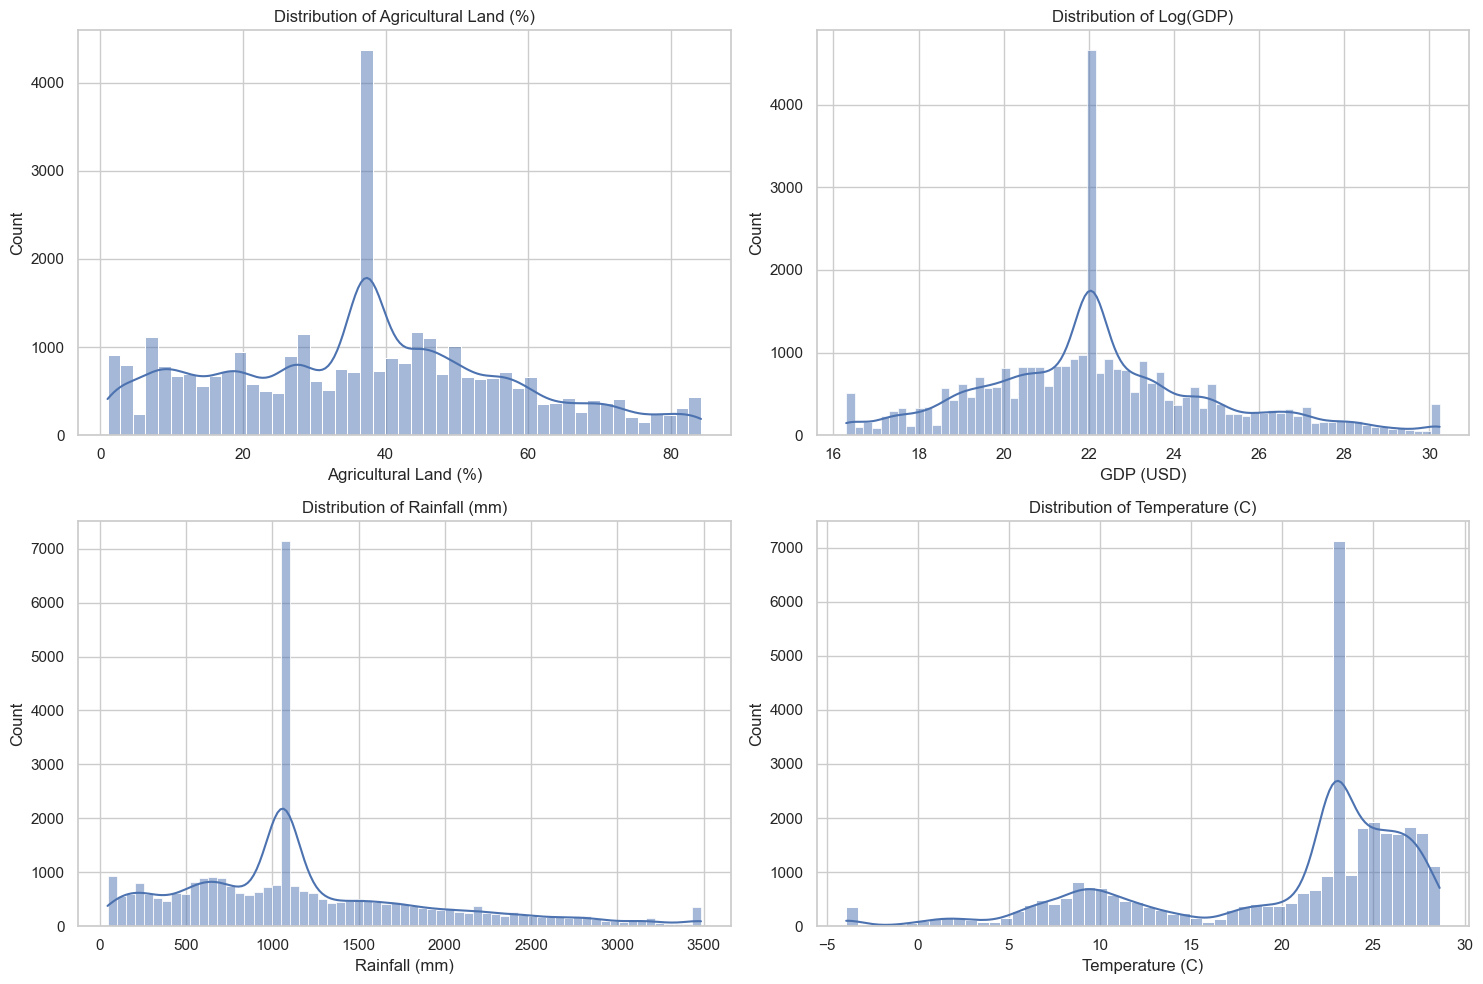

In [29]:
plt.figure(figsize=(15,10))
num_cols = ["Agricultural Land (%)", "GDP (USD)", "Rainfall (mm)", "Temperature (C)"]
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    
    if col == "GDP (USD)":
        sns.histplot(np.log1p(df[col]), kde=True)
        plt.title("Distribution of Log(GDP)")
    else:
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


### Correlation Analysis

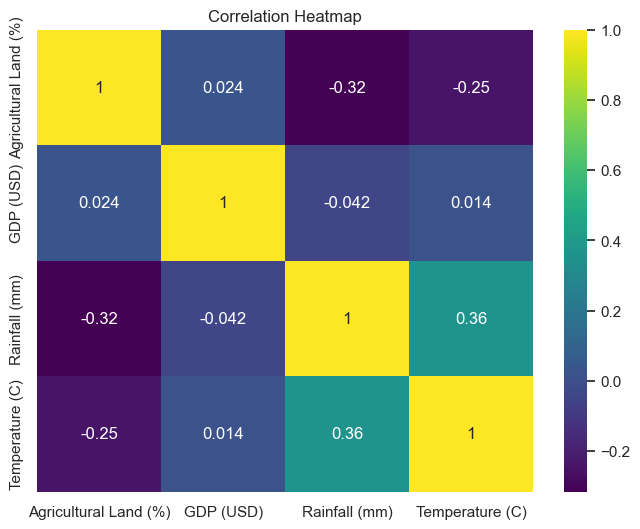

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


### Time-Series Trends

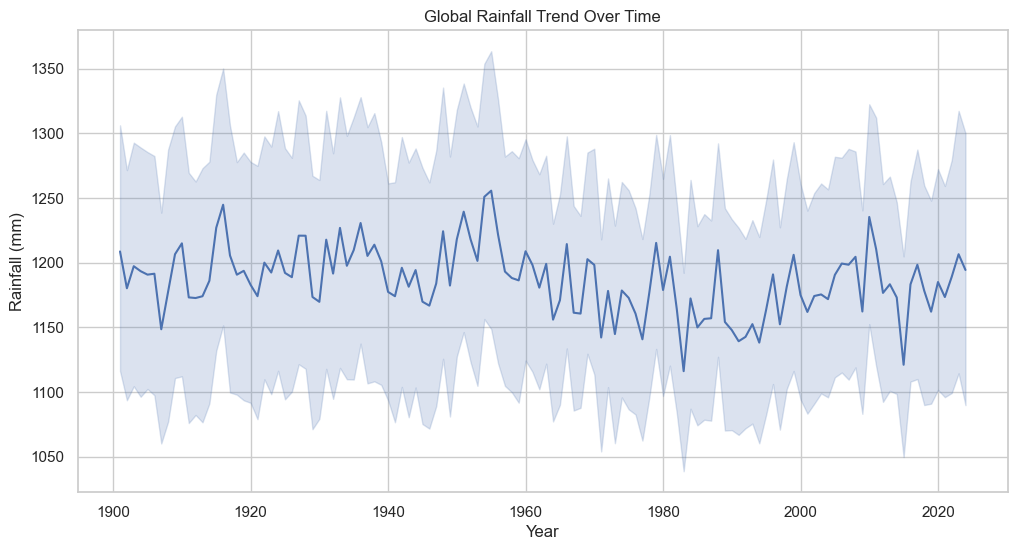

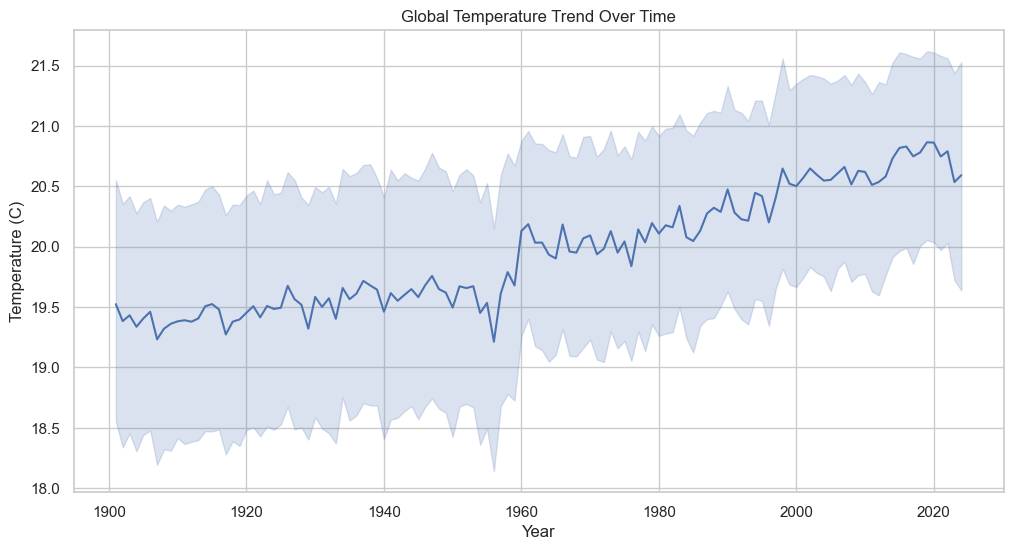

In [31]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Year", y="Rainfall (mm)")
plt.title("Global Rainfall Trend Over Time")
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Year", y="Temperature (C)")
plt.title("Global Temperature Trend Over Time")
plt.show()


### Region-wise Comparison

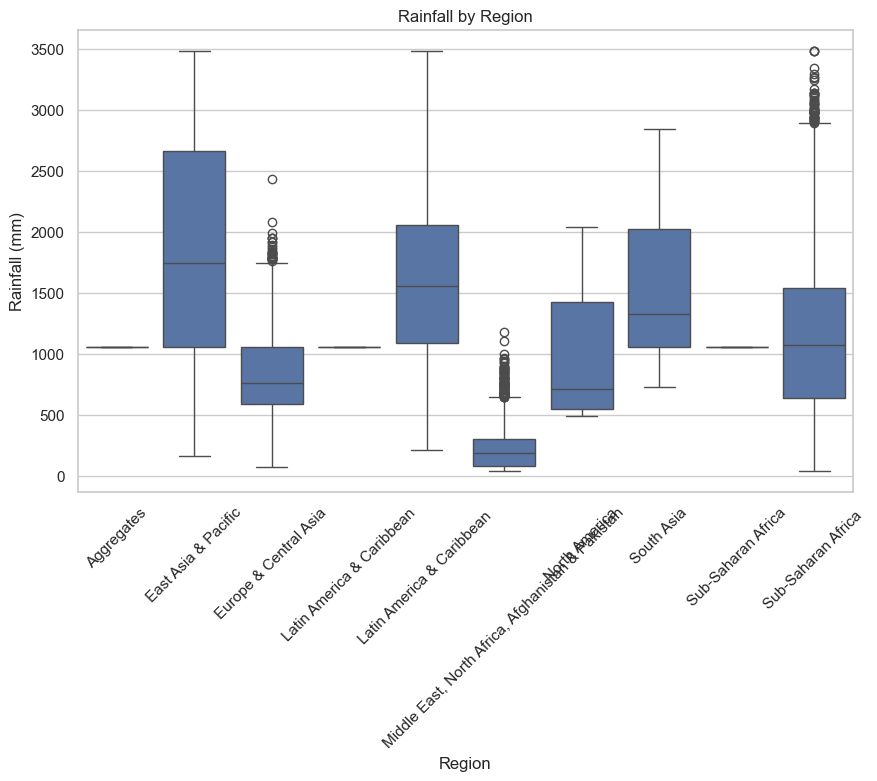

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Region", y="Rainfall (mm)")
plt.title("Rainfall by Region")
plt.xticks(rotation=45)
plt.show()


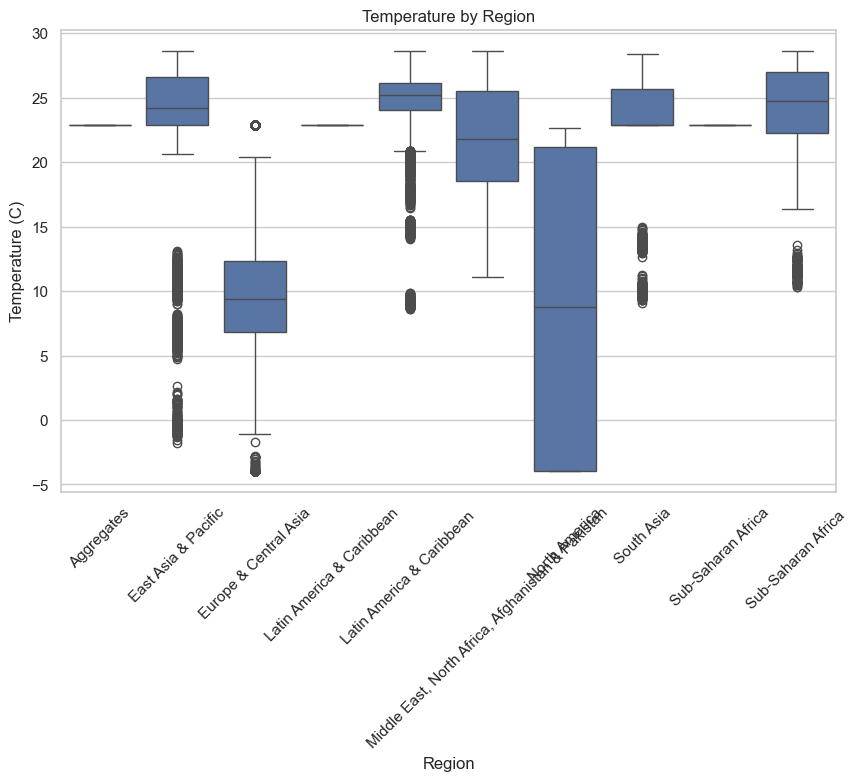

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Region", y="Temperature (C)")
plt.title("Temperature by Region")
plt.xticks(rotation=45)
plt.show()


### Pairplot for Quick Relationship Overview

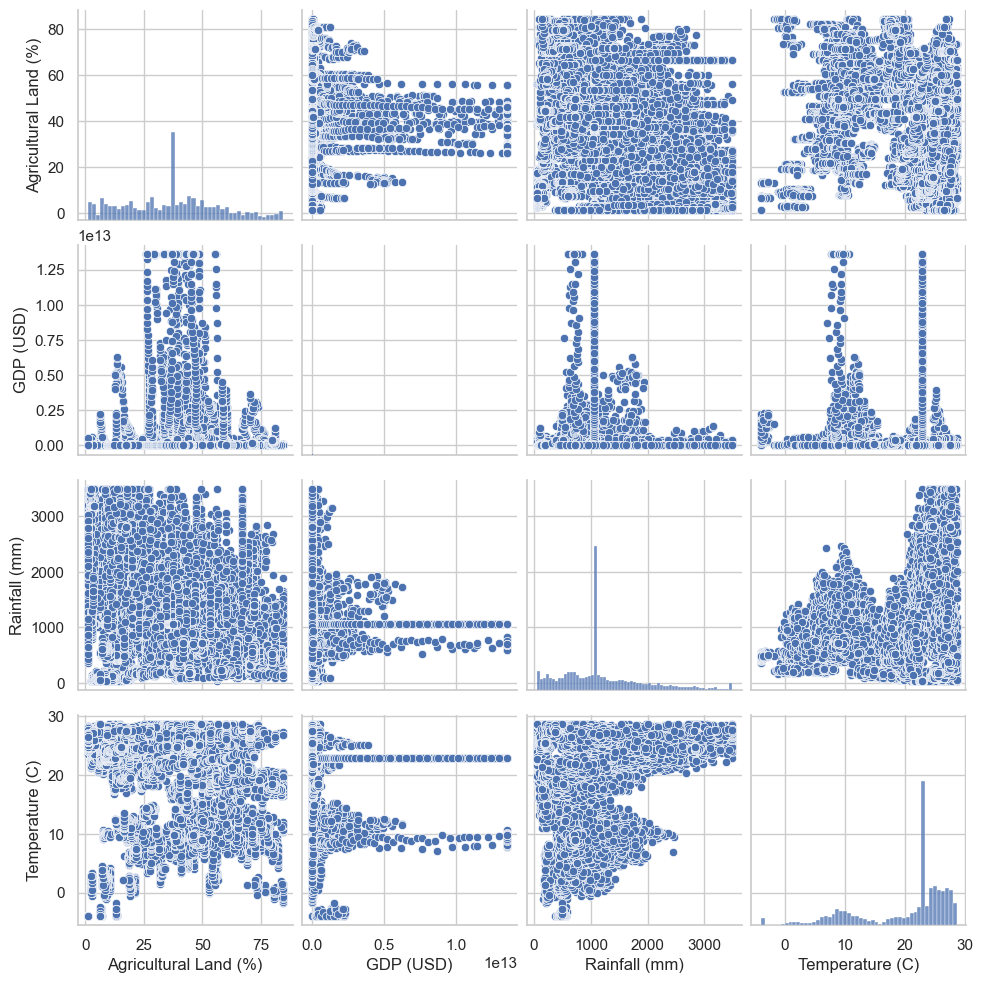

In [36]:
sns.pairplot(df[num_cols])
plt.show()


### Saving the Data Set

## 6. Save Processed Data

Save the consolidated World Bank dataset.

In [41]:
df_final.to_csv("datasets/world bank data.csv", index=False)